# Exploring regularization for logistic regression

## Goal

The goal of this lab is to explore the effect of regularization on the coefficients and accuracy of logistic regression models for a toy (wine) dataset

## Set up

In [27]:
import numpy as np
import pandas as pd

#np.random.seed(999)

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'

In [28]:
def normalize(X):
    X = X.copy()
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        if s>0.0:
            X[colname] = (X[colname] - u) / s
        else:
            X[colname] = (X[colname] - u)
    return X

## Load data, create 2-class problem

In [29]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}

X = df_wine.drop('y', axis=1)
y = df_wine['y']
print(f"{len(X)} records for classes {{0,1}} from {len(wine.data)} records")
X.head(2)

130 records for classes {0,1} from 178 records


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0


## Examine coefficients of nonregularized OLS model

**1. Split off validation/test set and train unregularized linear regression model**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)#, random_state=999)

In [31]:
lg = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**2. Compare the R^2 on training and test set**

In [32]:
print(f"{100*lg.score(X_train, y_train):.0f}% accuracy on training set")
print(f"{100*lg.score(X_test, y_test):.0f}% accuracy on test set")

100% accuracy on training set
96% accuracy on test set


**3. Extract $\beta_1, ..., \beta_p$ and count how many are close to 0**

Note: `sum(np.abs(x) < 1e-5)` is a decent way to check for values of `x` close to zero but not necessarily zero.  There is also `numpy.isclose()` but that is too strict (requires numbers to be really close to zero) for this exercise.

In [33]:
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?

0

<details>
<summary>Solution</summary>
<pre>
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?
</pre>
</details>

**4. Plot the coefficient index versus the value**

The plot should look something like:

<img src="wine-ols.png" width="200">

The following function is a handy way to plot the coefficients.

In [34]:
def plotbeta(beta, which, yrange=(-20_000, 20_000),fontsize=10, xlabel=True, ylabel=True, tick_format='{x:.1f}', ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(4.5,2.5))
    ax.bar(range(len(beta)),beta)
    if xlabel:
        ax.set_xlabel("Coefficient $\\beta_i$ for $i \\geq 1$", fontsize=fontsize)
    if ylabel:
        ax.set_ylabel("Coefficient value", fontsize=fontsize)
    if yrange is not None:
        ax.set_ylim(*yrange)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(tick_format))
    ax.set_title(f"{which} $\\overline{{\\beta}}$={np.mean(beta):.2f}, $\\sigma(\\beta)$={np.std(beta):.2f}", fontsize=fontsize)

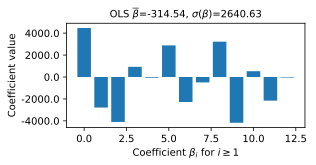

In [35]:
plotbeta(lg_beta, "OLS", yrange=None)
#plt.tight_layout(); plt.savefig("wine-ols.png",dpi=150,bbox_inches=0)

**5. Normalize the variables, retrain, check how many coefficients are close to 0**

In [36]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [53]:
lg = LogisticRegression(penalty='none', solver='lbfgs')
lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?

0

**6. Compare the R^2 on training and test set**

In [39]:
print(f"{100*lg.score(X_train, y_train):.0f}% accuracy on training set")
print(f"{100*lg.score(X_test, y_test):.0f}% accuracy on test set")

100% accuracy on training set
88% accuracy on test set


**7. Plot the coefficient index versus the value again after normalizing variables**

The plot should look something like:

<img src="wine-ols-norm.png" width="200">

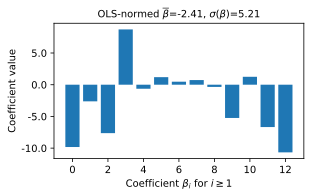

In [40]:
plotbeta(lg_beta, "OLS-normed", yrange=None)
#plt.tight_layout(); plt.savefig("wine-ols-norm.png",dpi=150,bbox_inches=0)

**Q.** Why is the scale of the coefficients different after normalizing the variables?

<details>
<summary>Solution</summary>
The scale the coefficients is a function of the X variable ranges so we would expect normalized variables to  yield smaller coefficients, unless of course the range of the X variables was already small.
</details>

## L1 Regularization

In [41]:
"""
sklearn says LogisticRegression arg C is "Inverse of regularization strength...
smaller values specify stronger regularization"
"""
lmbda=1

In [42]:
lg = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear', max_iter=1000)
lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?

6

**2. Compare the R^2 on training and test set**

In [44]:
print(f"{100*lg.score(X_train, y_train):.0f}% accuracy on training set")
print(f"{100*lg.score(X_test, y_test):.0f}% accuracy on test set")

100% accuracy on training set
88% accuracy on test set


**1. Plot the coefficient index versus the value**

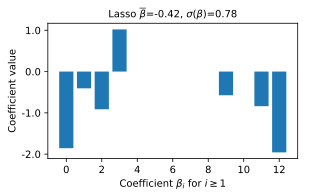

In [45]:
plotbeta(lg_beta, "Lasso", yrange=None, tick_format='{x:.1f}')
#plt.tight_layout(); plt.savefig("wine-l1.png",dpi=150,bbox_inches=0)

### Effect of $\lambda$ on regularization and accuracy scores

The goal of the following code snippets is to help you visualize how the $\lambda$ regularization parameter affects model parameters and associated training and testing accuracy. There are a number of important questions to answer following the code snippets.

lambda=1e-05: Zeros   0: train R^2 1.00 test R^2 0.88
lambda= 0.01: Zeros   4: train R^2 1.00 test R^2 0.88
lambda=  0.1: Zeros   5: train R^2 1.00 test R^2 0.88
lambda=    1: Zeros   6: train R^2 1.00 test R^2 0.88
lambda=   10: Zeros   9: train R^2 0.96 test R^2 0.88
lambda=  100: Zeros  13: train R^2 0.51 test R^2 0.23


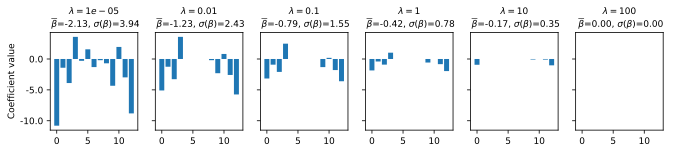

In [46]:
fig,axes = plt.subplots(1,6,figsize=(11,1.8), sharey=True)
for i,lmbda in enumerate([1e-5,.01,.1, 1, 10, 100]):
    lg = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear', max_iter=1000)
    lg.fit(X_train, y_train)
    accur = lg.score(X_train, y_train)
    accurt = lg.score(X_test, y_test)
    print(f"lambda={lmbda:5}: Zeros {sum(np.abs(lg.coef_[0]) < 1e-5):3d}: train R^2 {accur:.2f} test R^2 {accurt:.2f}")
    plotbeta(lg.coef_[0], f"$\\lambda={lmbda}$\n", ax=axes[i], fontsize=9, xlabel=False, ylabel=i==0, yrange=None)

## L2 Regularization

In [47]:
lmbda=1

In [48]:
lg = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear', max_iter=1000)
lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
lg_beta = lg.coef_[0]
sum(np.abs(lg_beta) < 1e-5) # how many close to 0?

0

**2. Compare the R^2 on training and test set**

In [50]:
print(f"{100*lg.score(X_train, y_train):.0f}% accuracy on training set")
print(f"{100*lg.score(X_test, y_test):.0f}% accuracy on test set")

100% accuracy on training set
88% accuracy on test set


**1. Plot the coefficient index versus the value**

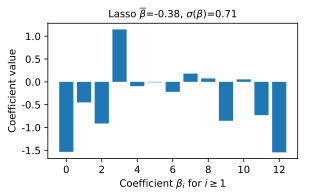

In [51]:
plotbeta(lg_beta, "Lasso", yrange=None, tick_format='{x:.1f}')
#plt.tight_layout(); plt.savefig("wine-l1.png",dpi=150,bbox_inches=0)

### Effect of $\lambda$ on regularization and accuracy scores

The goal of the following code snippets is to help you visualize how the $\lambda$ regularization parameter affects model parameters and associated training and testing accuracy. There are a number of important questions to answer following the code snippets.

lambda=1e-05: Zeros   0: train R^2 1.00 test R^2 0.88
lambda= 0.01: Zeros   0: train R^2 1.00 test R^2 0.88
lambda=  0.1: Zeros   0: train R^2 1.00 test R^2 0.88
lambda=    1: Zeros   0: train R^2 1.00 test R^2 0.88
lambda=   10: Zeros   0: train R^2 1.00 test R^2 0.88
lambda=  100: Zeros   0: train R^2 0.98 test R^2 0.85


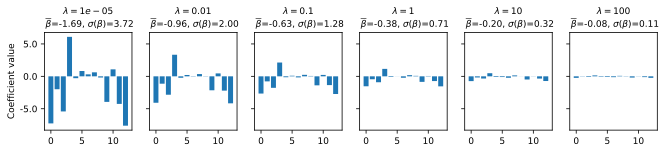

In [52]:
fig,axes = plt.subplots(1,6,figsize=(11,1.8), sharey=True)
for i,lmbda in enumerate([1e-5,.01,.1, 1, 10, 100]):
    lg = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear', max_iter=1000)
    lg.fit(X_train, y_train)
    accur = lg.score(X_train, y_train)
    accurt = lg.score(X_test, y_test)
    print(f"lambda={lmbda:5}: Zeros {sum(np.abs(lg.coef_[0]) < 1e-5):3d}: train R^2 {accur:.2f} test R^2 {accurt:.2f}")
    plotbeta(lg.coef_[0], f"$\\lambda={lmbda}$\n", ax=axes[i], fontsize=9, xlabel=False, ylabel=i==0, yrange=None)